# Classification

## Dataset

In [32]:
import numpy as np
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='datasets')
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
X, y = mnist["data"], mnist["target"]

In [34]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


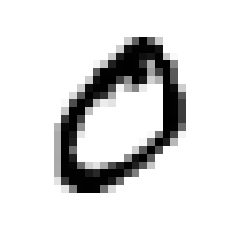

In [35]:
# Display one digit
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

In [36]:
print ('Label' , y[0])

Label 0


In [37]:
# Train and test sets
import numpy.random as rnd
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Shuffle data
shuffle_index = rnd.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier

In [38]:
y_train_5 =(y_train == 5)
y_test_5= (y_test == 5)

In [39]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
sgd_clf.predict([some_digit])

array([False])

In [41]:
# A personalized cross validation function
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
# Get representative samples
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.958
0.96345
0.96325


In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.88667267, 0.85789289, 0.88898335])

In [43]:
# Random classifier
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9086 , 0.9102 , 0.91015])

### Confusion matrix

In [44]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53493,  1086],
       [ 1220,  4201]], dtype=int64)

#### Precision and recall

In [46]:
from sklearn.metrics import precision_score, recall_score
print('Precision = ', precision_score(y_train_5, y_train_pred))
print('Recall = ', recall_score(y_train_5,y_train_pred))

Precision =  0.7945905050122943
Recall =  0.7749492713521491


In [47]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846469929025028

#### Precision-recall tradeoff

In [48]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-11051.00410493])

In [49]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [50]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [52]:
# Return decision scores (cross)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method = 'decision_function')

In [54]:
# Precision -  recall functions
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

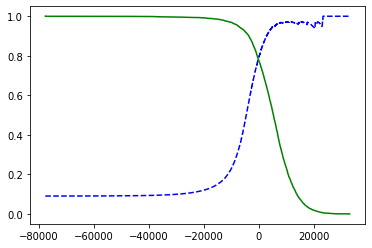

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [58]:
# Threshold 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))


0.9
0.6474820143884892
